### Etude des variables dans la catégorie solvabilité

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("data.csv")
data.columns.tolist()
# Supprimer les espaces en trop autour des noms de colonnes
data.columns = data.columns.str.strip()

In [2]:
flux_tresorerie = [
    "Cash Reinvestment %",
    "Cash Flow to Sales",
    "Cash Flow to Total Assets",
    "Cash Flow to Liability",
    "CFO to Assets",
    "Cash Flow to Equity"
]


data_solv = data[[col for col in data.columns if col in flux_tresorerie]]
len(flux_tresorerie)

6

<Axes: >

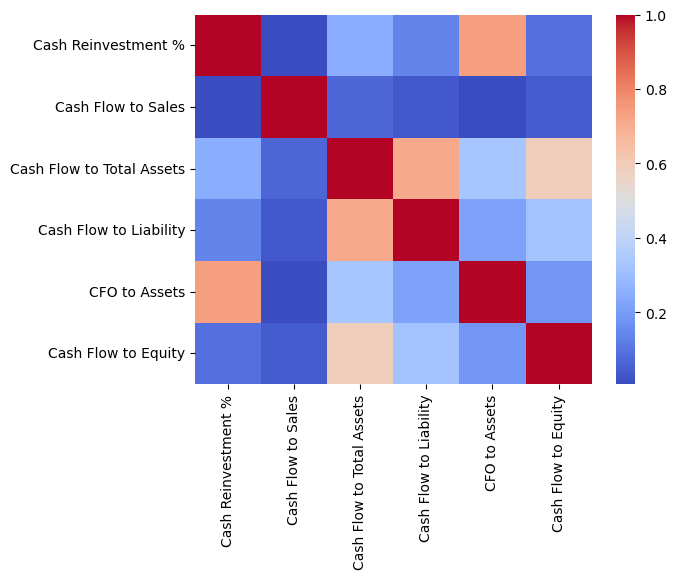

In [3]:
corr = data_solv.corr()
sns.heatmap(corr, cmap='coolwarm')

0.16090014154283325


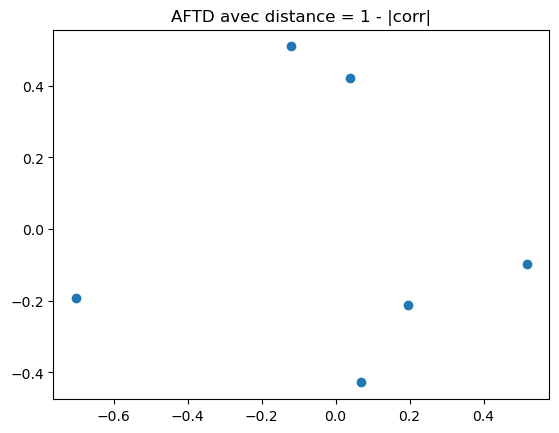

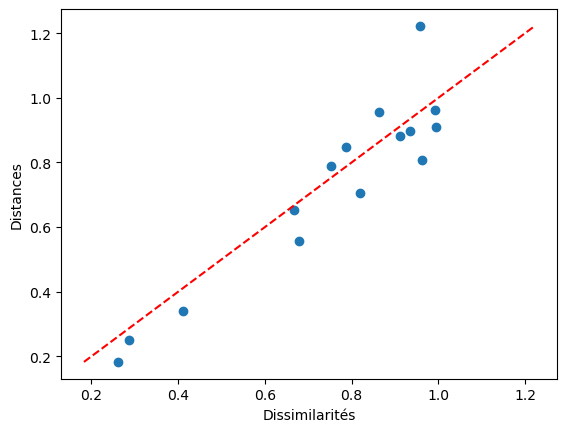

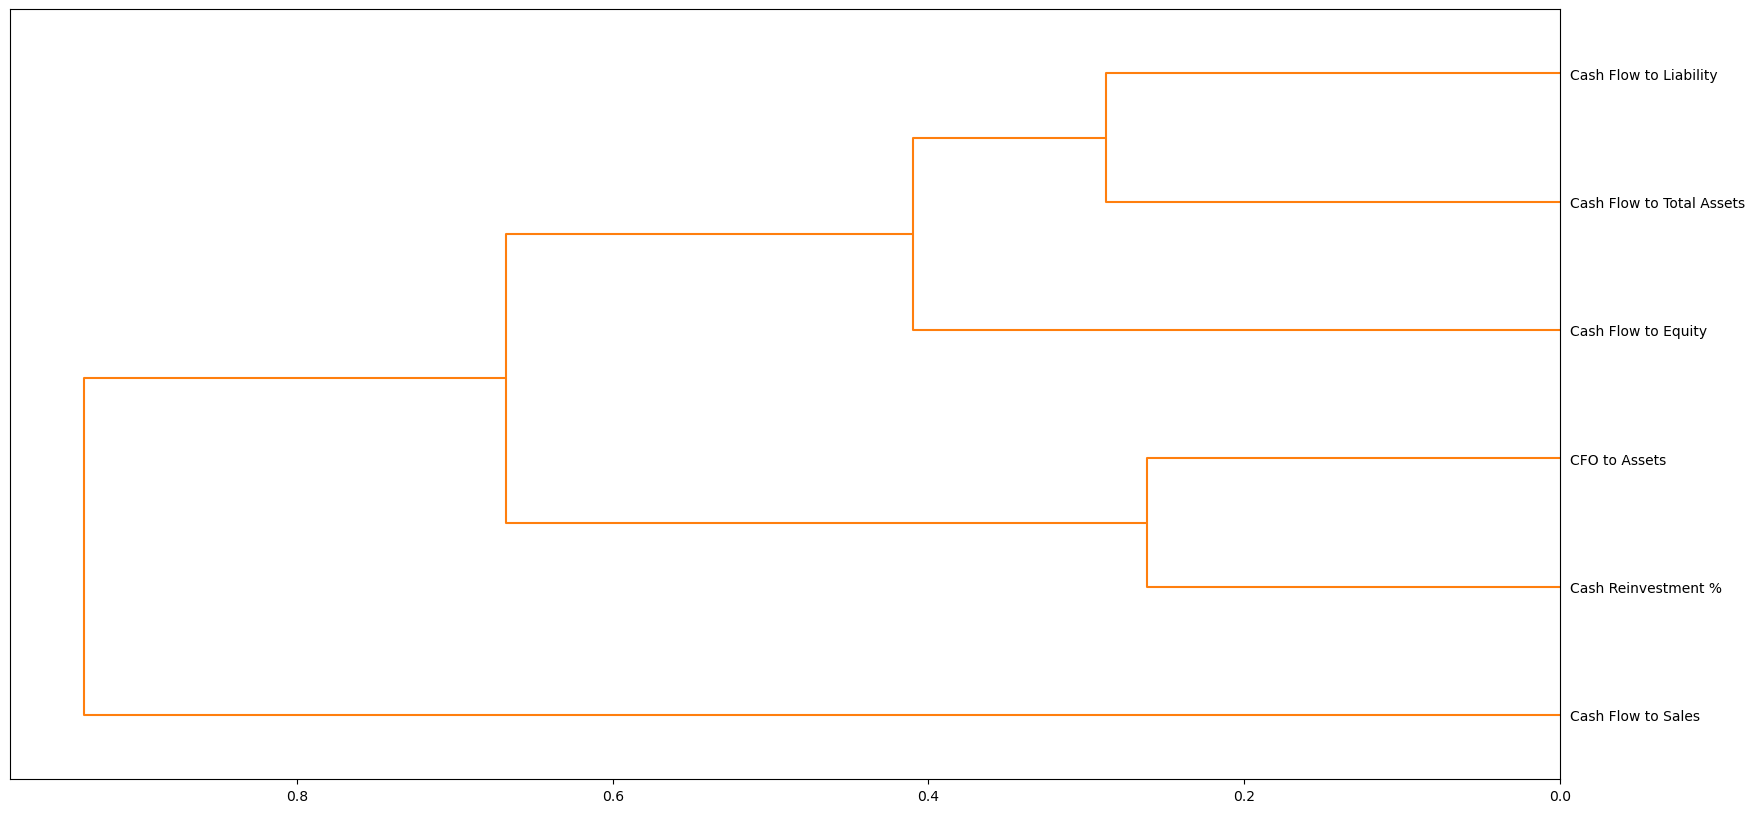

In [4]:
from sklearn.manifold import MDS
from src1.utils import plot_Shepard
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from src1.utils import plot_dendrogram

# Méthode 1 : distance = 1 - |corrélation|
distance1 = 1-abs(corr)


aftd = MDS(n_components=2, dissimilarity='precomputed')
dist1 = aftd.fit_transform(distance1)
print(aftd.stress_)
plt.scatter(*dist1.T)
plt.title("AFTD avec distance = 1 - |corr|")
plt.show()
plot_Shepard(aftd)
plt.show()

cls = AgglomerativeClustering(metric="precomputed", linkage="single", n_clusters=None, distance_threshold=0).fit(distance1)
plt.figure(figsize=(20, 10))
plot_dendrogram(cls, color_threshold=1, labels=corr.columns, orientation="left")

In [5]:
data_solv['Bankrupt'] = data['Bankrupt?'].values
data_solv['Liability-Assets Flag']=data['Liability-Assets Flag'].values

C:\Users\arthu\AppData\Local\Temp\ipykernel_8760\3523034060.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_solv['Bankrupt'] = data['Bankrupt?'].values
C:\Users\arthu\AppData\Local\Temp\ipykernel_8760\3523034060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_solv['Liability-Assets Flag']=data['Liability-Assets Flag'].values


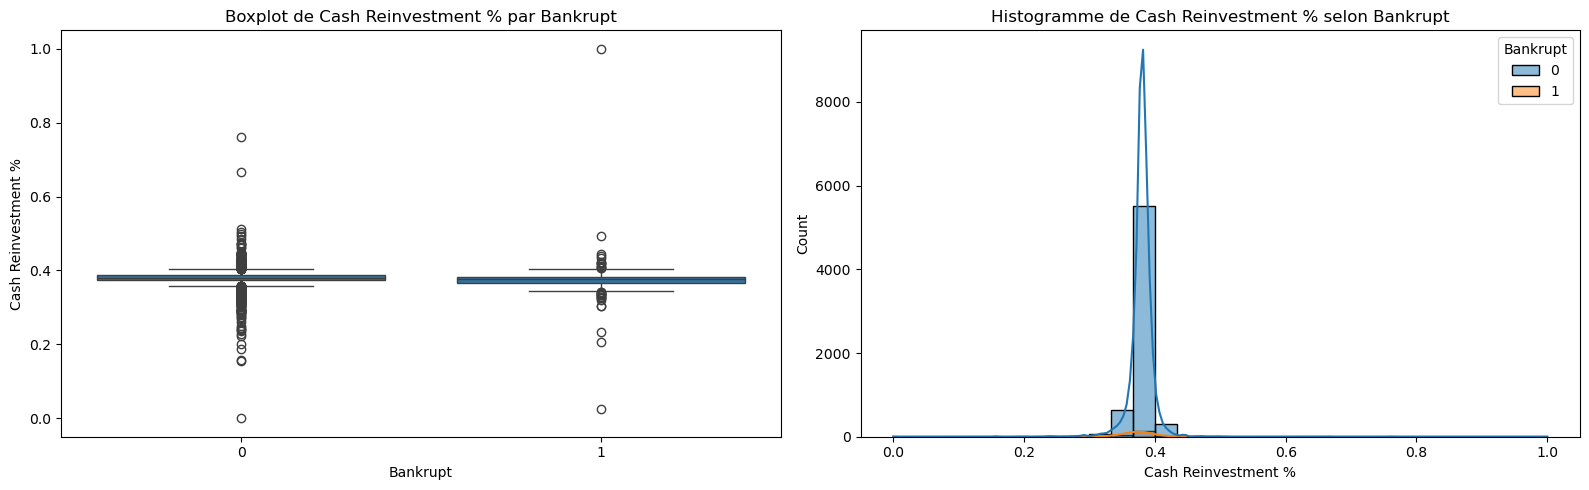

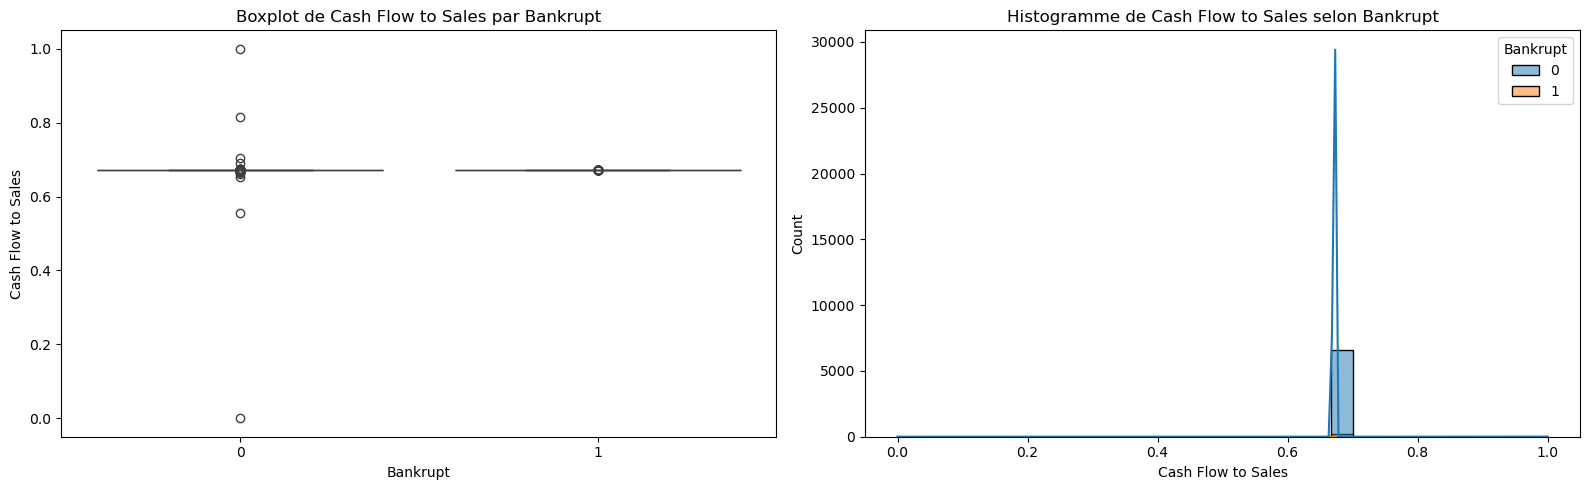

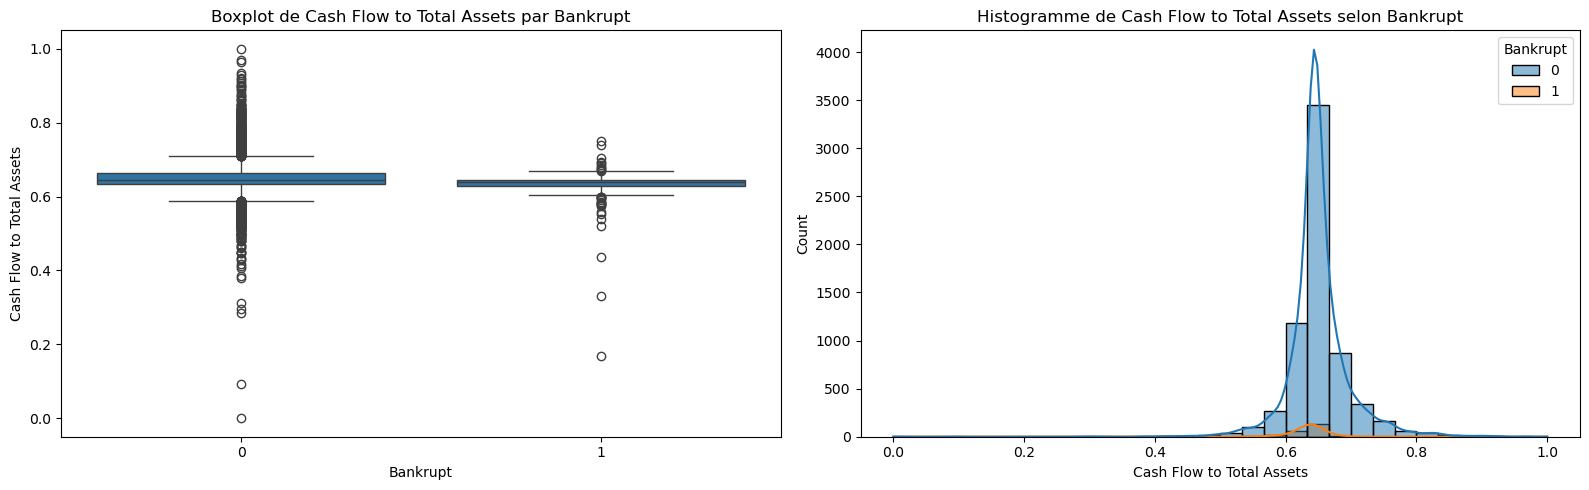

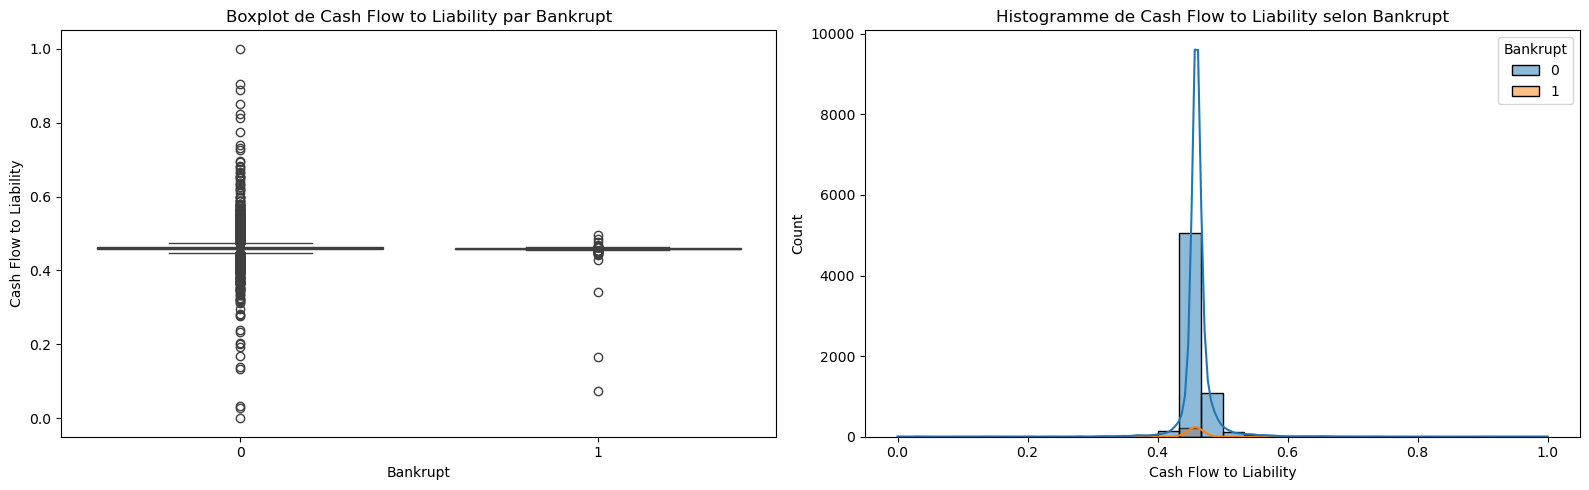

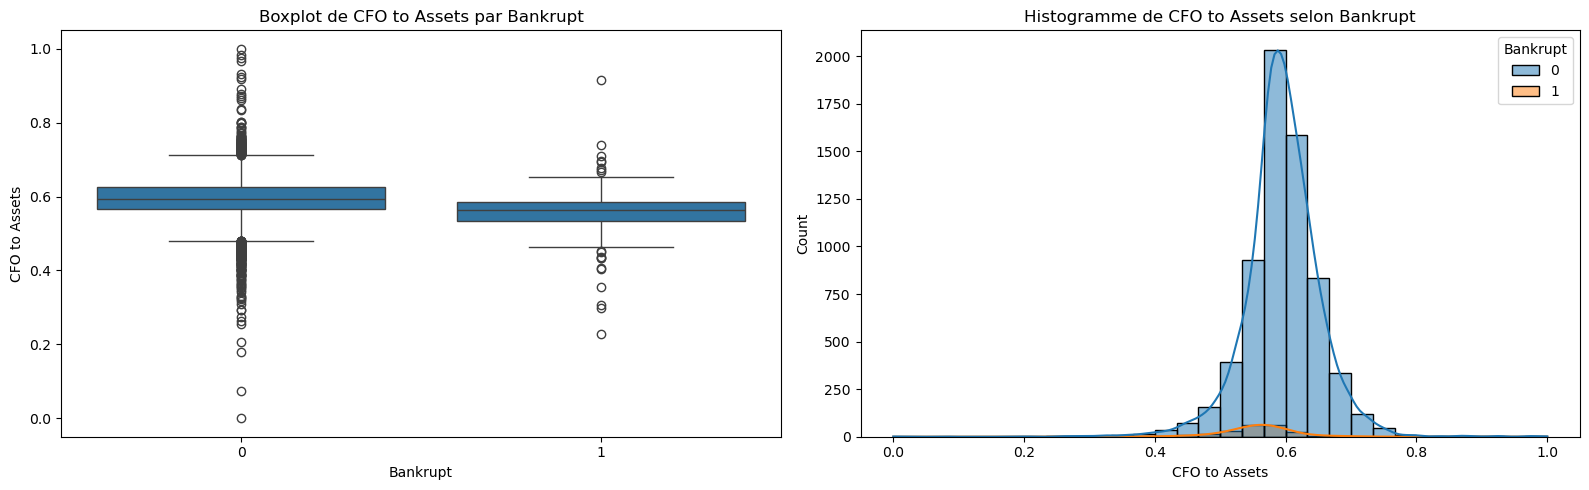

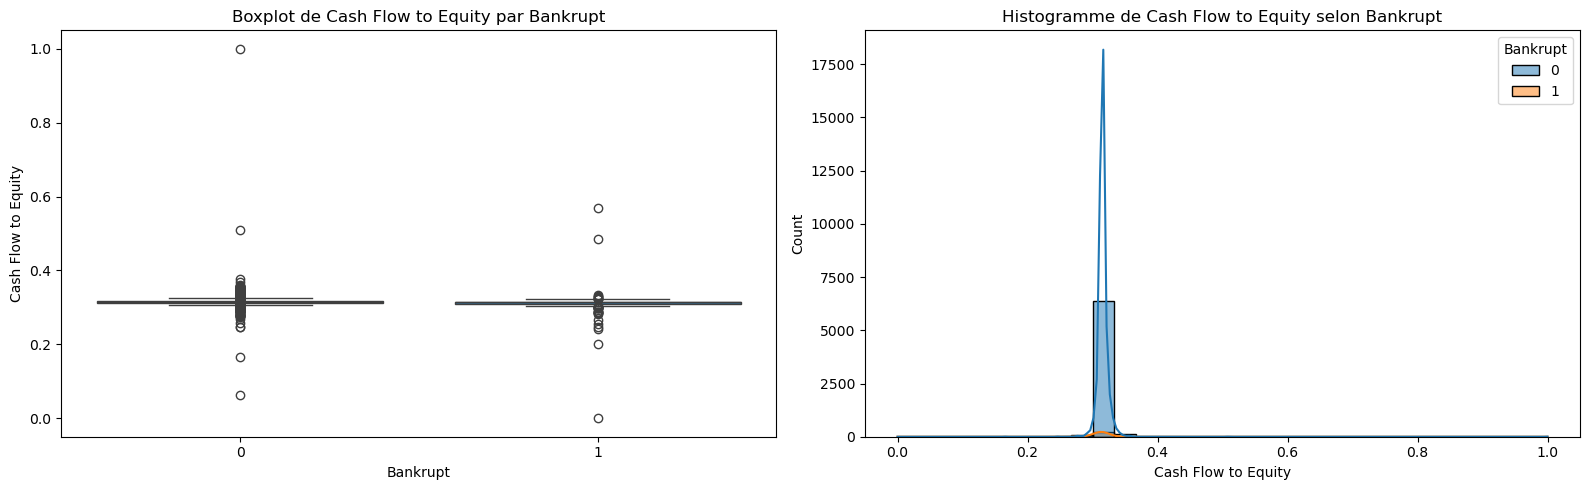

In [6]:
for col in flux_tresorerie:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

    # Boxplot
    sns.boxplot(x='Bankrupt', y=col, data=data_solv, ax=axes[0])
    axes[0].set_title(f'Boxplot de {col} par Bankrupt')

    # Histogramme
    sns.histplot(data=data_solv, x=col, hue='Bankrupt', kde=True, bins=30, ax=axes[1])
    axes[1].set_title(f'Histogramme de {col} selon Bankrupt')

    plt.tight_layout()
    plt.show()


Possibilité de passer en variable qualitative les variables quantitatives suivantes : 
- Cash Flow to Total Assets, 
-  CFO to Assets

Pour fair autre chose que de la recherche de faillite

### CAH sur les entreprises

In [7]:
data_quant = data[[col for col in data.columns if col in flux_tresorerie]]

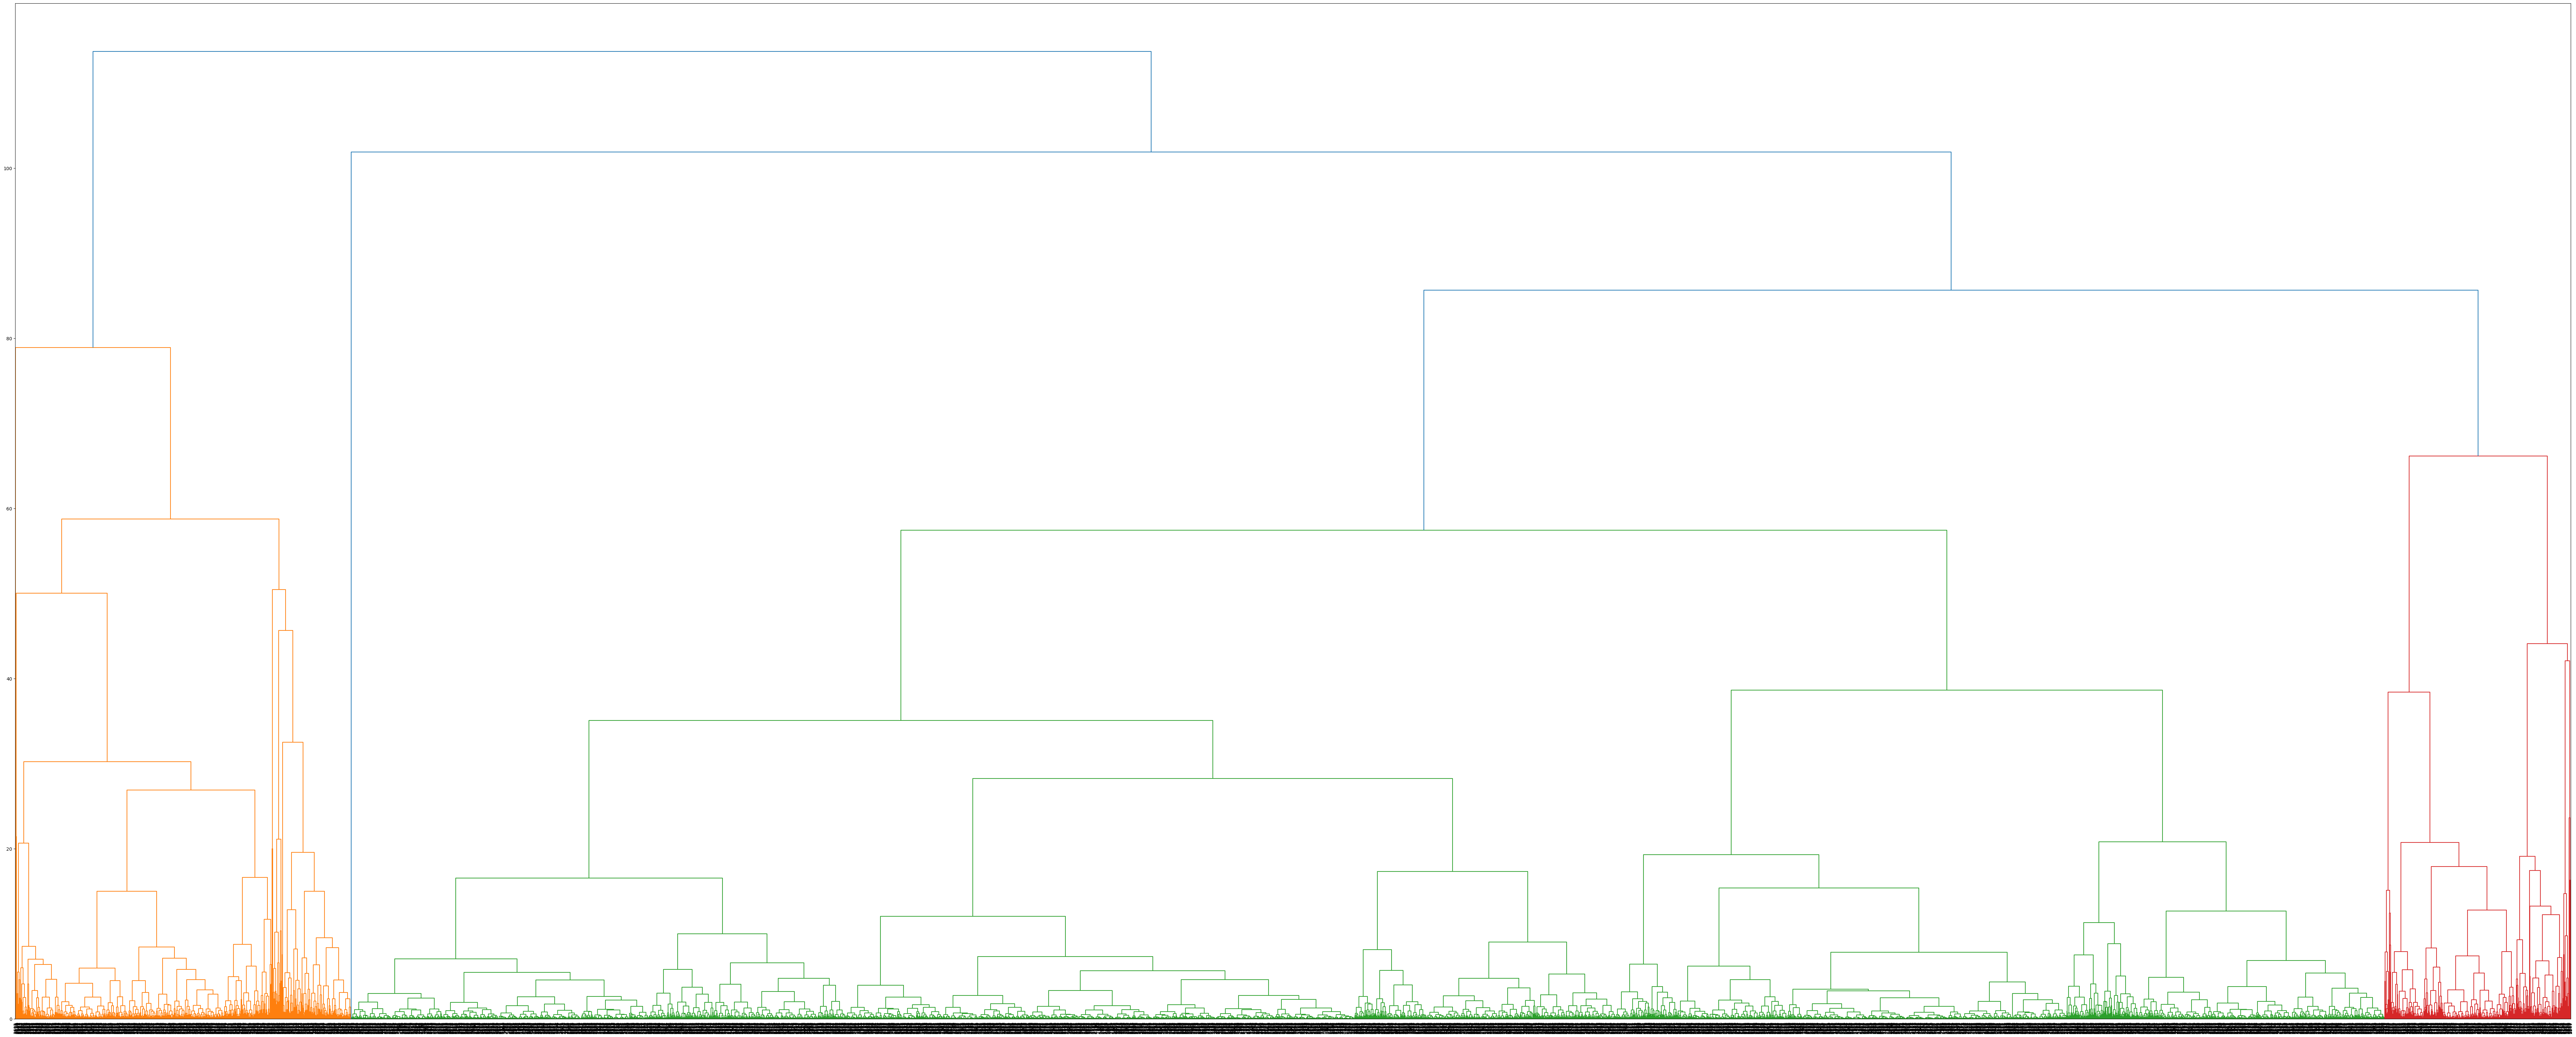

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from src1.utils import plot_dendrogram

# Normalisation des variables numériques
norm = StandardScaler()
quantiative_norm = norm.fit_transform(data_quant)

cls = AgglomerativeClustering(metric="euclidean", linkage="ward", distance_threshold=0, n_clusters=None)
cls.fit(quantiative_norm)
plt.figure(figsize=(100, 40))
plot_dendrogram(cls)

On remarque 3 clusters

### AFTD sur les entreprises

In [14]:
# Prend trop de temps
#aftd = MDS(n_components=2, dissimilarity='euclidean')
#dist = aftd.fit_transform(quantiative_norm)
#print(aftd.stress_)
#plt.scatter(*dist.T)
#plt.show()

In [ ]:
#plot_Shepard(aftd)
#plt.show()

### ACP

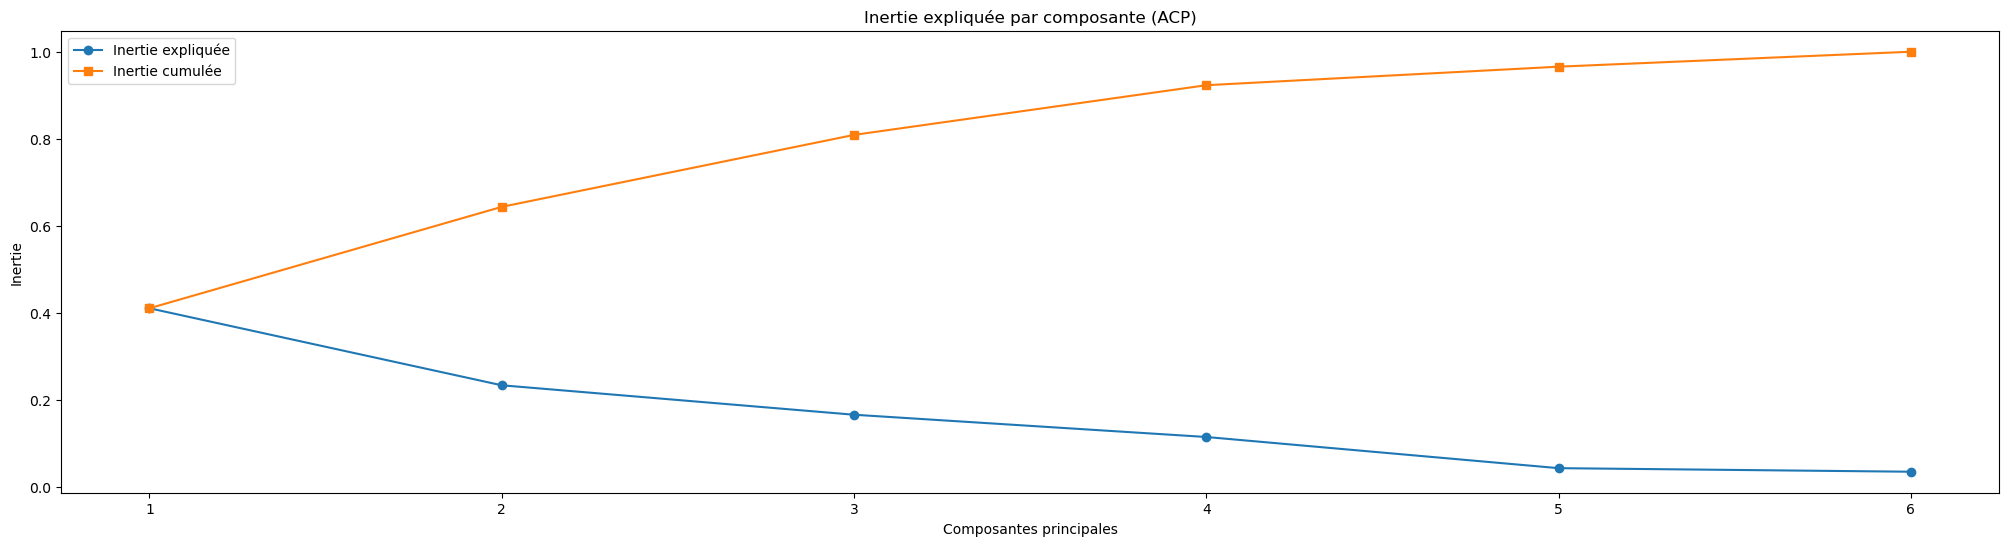

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

cls = PCA()
pcs = cls.fit_transform(quantiative_norm)

# Inertie expliquée et cumulée
inertie_exp = cls.explained_variance_ratio_
cumul_inertie = inertie_exp.cumsum()

plt.figure(figsize=(25, 6))
plt.plot(range(1, len(inertie_exp) + 1), inertie_exp, marker='o', label="Inertie expliquée")
plt.plot(range(1, len(cumul_inertie) + 1), cumul_inertie, marker='s', label="Inertie cumulée")
plt.xticks(range(1, len(inertie_exp) + 1))
plt.xlabel("Composantes principales")
plt.ylabel("Inertie")
plt.title("Inertie expliquée par composante (ACP)")
plt.legend()

<Axes: xlabel='PC5', ylabel='PC6'>

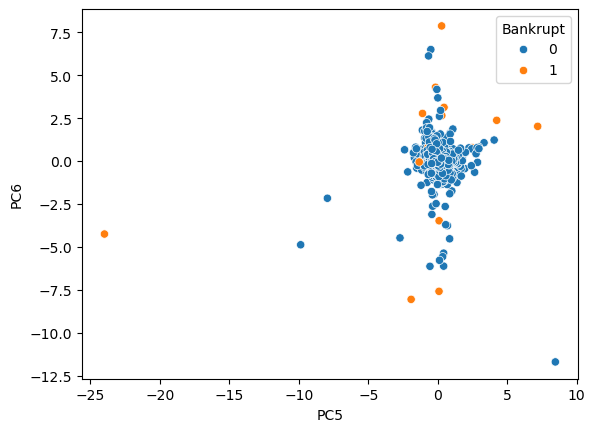

In [25]:
data_acp = pd.DataFrame(pcs, columns=[f"PC{i}" for i in range(1, len(inertie_exp)+1)])
data_acp['Bankrupt'] = data['Bankrupt?'].values
data_acp['Liability-Assets Flag']=data['Liability-Assets Flag'].values

sns.scatterplot(x="PC5", y="PC6", hue=data_acp.Bankrupt, data=data_acp)